In [11]:
import pymc3 as pm
from pymc3 import model_to_graphviz, Continuous, Discrete
import pandas as pd
import numpy as np

In [12]:
%matplotlib inline
import seaborn as sns
import arviz as az

In [88]:
import networkx

In [14]:
from pymc3.theanof import floatX
import theano.tensor as tt

In [15]:
data = pd.read_csv("../data_raw/gene_summary.tsv", sep="\t")

In [65]:
filter_genes = list(data.id.values[:4]) + \
            ["POLR2C", "POLR1B", "PSMC1", "PSMD4", "TH"] + \
            list(data.id.values[40:50])

In [66]:
filter_data = data[data.id.isin(filter_genes)]

In [67]:
filter_data

,id,num,neg|score,neg|p-value,neg|fdr,neg|rank,neg|goodsgrna,neg|lfc,pos|score,pos|p-value,pos|fdr,pos|rank,pos|goodsgrna,pos|lfc
0,PSMC5,10,7.342000e-13,0.000005,0.000114,1,9,-0.098003,0.999990,0.999990,0.999995,90,0,-0.098003
1,PSMB1,10,3.090900e-12,0.000005,0.000114,2,9,-0.116810,1.000000,1.000000,0.999995,91,0,-0.116810
2,PSMC3,10,9.788600e-10,0.000005,0.000114,3,9,-0.052708,0.999560,0.999430,0.999995,89,0,-0.052708
3,POLR3K,10,2.574700e-07,0.000005,0.000114,4,8,-0.048451,0.970720,0.970730,0.999995,85,0,-0.048451
4,PSMC1,10,1.674400e-05,0.000115,0.002091,5,7,-0.041440,0.951490,0.951780,0.999995,81,0,-0.041440
13,PSMD4,10,1.420900e-01,0.290850,0.995418,14,3,-0.001814,0.341440,0.497830,0.999995,44,1,-0.001814
16,TH,10,1.745800e-01,0.333640,0.995418,17,3,-0.001190,0.413870,0.560790,0.999995,49,1,-0.001190
28,POLR2C,10,3.483400e-01,0.520110,0.995418,29,1,0.002940,0.114530,0.242440,0.885564,22,3,0.002940
35,POLR1B,10,4.104200e-01,0.569030,0.995418,36,2,-0.000904,0.010147,0.037418,0.555505,6,3,-0.000904
40,FEZF2,10,4.383800e-01,0.590170,0.995418,41,2,0.005548,0.114610,0.242510,0.885564,23,3,0.005548


In [76]:
G = frame.subgraph(np.sort(filter_genes))
adj = nx.to_numpy_matrix(G, 
                         nodelist=np.sort(G.nodes()), 
                         weight='weight')

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


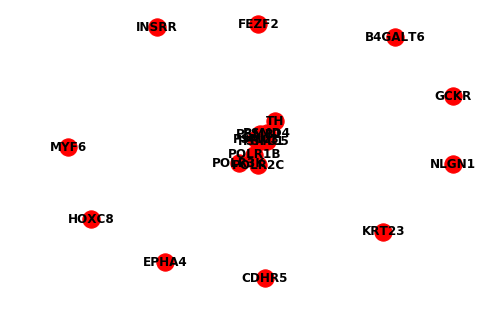

In [79]:
nodes = np.sort(G.nodes());
g = nx.from_numpy_array(adj);
nx.draw(g, font_weight='bold', 
        labels={n: nodes[n] for n in g.nodes()});

In [91]:
class BinaryMRF(Discrete):
    def __init__(self, G, node_labels = None, **kwargs):
        if isinstance(G, networkx.classes.graph.Graph):        
            self.__node_labels = np.sort(G.nodes())
            self.__adj = nx.to_numpy_matrix(G, nodelist=self.__node_labels, weight='weight')
        elif isinstance(G, networkx.classes.graph.Graph) or isinstance(G, numpy.ndarray):
            if node_labels is None:
                raise ValueError("Please provide node labels")
            self.__node_labels = node_labels
            self.__adj =  G
        self.mode = 1
        super().__init__(**kwargs)

#     def _markov_blank(self, idx):
#         children = np.where(self.__adj[i, ] != 0)
#         parents = np.where(self.__adj[, i] != 0)      
#         return np.unique(np.concatenate(children, parents))

#     def edge_potential(self, labels, x):        
#         mb = self._markov.blanket(x, adj)
#         s1 = np.sum((labels[mb] == labels[x]) * adj[mb, x]) 
#         s2 = np.sum((labels[mb] != labels[x]) * adj[mb, x])
#         return s1 - s2

#     def _energy(self, a, labels, theta):
#         energy <- -log(LaplacesDemon::dinvgamma(a, 5, 1))
#       for (i in seq(data)):
#       {
#         if (labels[i] == 1) {
#           energy <- energy - log(dbeta(data[i], a, 1))
#         } else if (labels[i] == -1) {
#           energy <- energy - log(dunif(data[i]))
#         } else stop("what you doing, bra")

#         energy <- energy + theta * .edge.potential(labels, i, adj)
#       }

#         return energy
        
    def random(self, point=None, size=None):
        for 

In [92]:
with pm.Model() as model:
    A = BinaryMRF('A', G)
    B = pm.Normal('B', mu=20+A, sd=10)

AttributeError: 'BinaryMRF' object has no attribute 'logp'

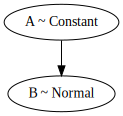

In [44]:
model_to_graphviz(model, )

In [46]:
with model:
    pm.sample(1000, ninit=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [A]
>NUTS: [B]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3084.93draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


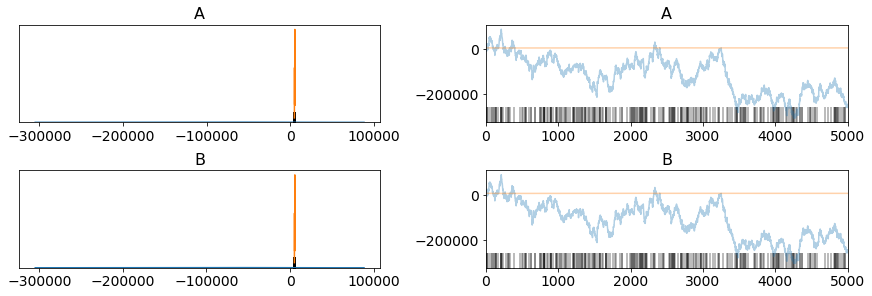

In [47]:
az.plot_trace(trace);

In [93]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

def make_likelihood(true_variances):
    return tfd.MultivariateNormalDiag(
        scale_diag=tf.sqrt(true_variances))

dims = 10
dtype = np.float32
true_variances = tf.linspace(dtype(1), dtype(3), dims)
likelihood = make_likelihood(true_variances)

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 1.13.1; Detected an installation of version 1.10.0. Please upgrade TensorFlow to proceed.

In [ ]:

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=1000,
    current_state=tf.zeros(dims),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=likelihood.log_prob,
      step_size=0.5,
      num_leapfrog_steps=2),
    num_burnin_steps=500)

# Compute sample stats.
sample_mean = tf.reduce_mean(states, axis=0)
sample_var = tf.reduce_mean(
    tf.squared_difference(states, sample_mean),
    axis=0)
